In [55]:
import dscribe
import numpy as np
import os
from tqdm import tqdm
from dscribe.descriptors import SOAP

from ase.io import read
from ase.build import molecule
from ase import Atoms
from ase.visualize import view
import math
import sklearn

In [56]:
import tensorflow as tf
import keras
import numpy as np
from tqdm import tqdm

from keras.models import Sequential
from keras.applications import ResNet50
from keras.layers import Dense, Dropout, Activation, Flatten, Input, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, concatenate
from keras.utils import np_utils
from keras import Model
from keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt

In [57]:
%ls

'Dscribe Encode.ipynb'   feature_generation/
 encode_data.py          Invariance.ipynb


In [58]:
labels = []
elems = []
for f in tqdm(os.listdir("../data/coordinates_TS/")):
    if f.endswith(".xyz"):
        elems.append(read("../data/coordinates_TS/" + f))
        labels.append(f)

100%|██████████| 1947/1947 [00:01<00:00, 1015.04it/s]


In [59]:
print(len(elems))

1947


In [61]:
species = ["H", "C", "O", "N", "Ir", "As", "S", "P", "Br", "Cl", "F", "I"]
print(len(species))
rcut = 8.0
nmax = 3
lmax = 1

# Setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=False,
    rcut=rcut,
    nmax=nmax,
    lmax=lmax,
)

print(soap.get_number_of_features())

12
1332


In [62]:
atom_index = [[0]] * len(elems)

feature_vectors = soap.create(elems, positions=atom_index)

In [63]:
feature_vectors.shape

(1947, 1332)

In [64]:
view(elems[520], viewer='x3d')

In [65]:
%mkdir ../data/soap
np.save("../data/soap/features.npy", feature_vectors)
np.save("../data/soap/labels.npy", np.array(labels))

mkdir: cannot create directory ‘../data/soap’: File exists


In [66]:
elems[85][0]

Atom('Ir', [-0.189433, -0.19121, -0.389123], index=0)

In [67]:
import csv

barriers = dict()

with open('../data/vaskas_features_properties_smiles_filenames.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        #images.append(row[0])
        #elos.append(row[1])
        barriers[row[93]] = float(row[91])

In [68]:
features_cnn = np.load("../data/soap/features.npy")
names = np.load("../data/soap/labels.npy")
labels = []

for x in range(len(features_cnn)):
  labels.append(barriers[names[x][:-7]])

labels = np.array(labels)

print(features_cnn.shape)
print(labels.shape)

(1947, 1332)
(1947,)


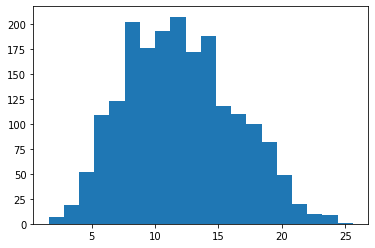

11.970210580380073


In [69]:
import matplotlib.pyplot as plt

plt.hist(labels, bins = 20)
plt.show()

print(np.mean(labels))

In [70]:
def reg_stats(y_true,y_pred,scaler=None):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  if scaler:
    y_true_unscaled = scaler.inverse_transform(y_true)
    y_pred_unscaled = scaler.inverse_transform(y_pred)
  r2 = sklearn.metrics.r2_score(y_true,y_pred)
  mae = sklearn.metrics.mean_absolute_error(y_true_unscaled, y_pred_unscaled)
  return r2,mae

In [71]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

In [72]:
from sklearn.preprocessing import StandardScaler
inputScaler = StandardScaler()
inputScaler.fit(features_cnn)

features_cnn = inputScaler.transform(features_cnn)

In [73]:
(trainX_cnn, testX_cnn, trainY, testY) = train_test_split(features_cnn, labels, test_size=0.2, random_state=32)

In [74]:
from sklearn.preprocessing import StandardScaler
barrierScaler = StandardScaler()
barrierScaler.fit(labels.reshape(-1, 1))

trainY_scaled = barrierScaler.transform(trainY.reshape(-1,1))
testY_scaled = barrierScaler.transform(testY.reshape(-1,1))

In [76]:
from keras.models import Model
from keras import regularizers


model_full = Sequential()

"""
model = keras.models.load_model("/content/drive/MyDrive/Uni/Bachelorarbeit/pretrained_conv_2d_30_trans_rot.h5")
model.summary()

model_autocor = keras.models.load_model("/content/drive/MyDrive/Uni/Bachelorarbeit/model_autocor.h5")
model_autocor.summary()


modelTransfer = Sequential(model.layers[0:-4])
for layer in modelTransfer.layers:
    layer.trainable = False

model_full.add(modelTransfer)
"""

#model_full.add(keras.layers.Conv3D(4, [5,5,5], padding='valid'))
#model_full.add(keras.layers.Dropout(0.2))
#model_full.add(keras.layers.BatchNormalization())

#model_full.add(keras.layers.Conv3D(8, [4,4,4], padding='valid'))
#model_full.add(keras.layers.Dropout(0.2))
#model_full.add(keras.layers.BatchNormalization())

#model_full.add(keras.layers.Conv1D(8, [30], padding='valid'))
#model_full.add(keras.layers.Dropout(0.2))
#model_full.add(keras.layers.BatchNormalization())

model_full.add(keras.layers.Flatten())

#model_full.add(Dense(512, activation="relu", kernel_regularizer='l2'))
#model_full.add(keras.layers.Dropout(0.3))
#model_full.add(keras.layers.BatchNormalization())

#model_full.add(Dense(512, activation="relu", kernel_regularizer='l2'))
#model_full.add(keras.layers.Dropout(0.3))
#model_full.add(keras.layers.BatchNormalization())

#model_full.add(Dense(256, activation="relu", kernel_regularizer='l2'))
#model_full.add(keras.layers.Dropout(0.3))
#model_full.add(keras.layers.BatchNormalization())

model_full.add(Dense(128, activation="relu", kernel_regularizer='l2'))
model_full.add(keras.layers.Dropout(0.5))
#model_full.add(keras.layers.BatchNormalization())

model_full.add(Dense(64, activation="relu", kernel_regularizer='l2'))
#model_full.add(keras.layers.Dropout(0.3))
model_full.add(keras.layers.BatchNormalization())

#model_full.add(Dense(8, activation="relu"))
#model_full.add(keras.layers.Dropout(0.3))
#model_full.add(keras.layers.BatchNormalization())

model_full.add(Dense(1, kernel_regularizer='l2'))

"""
modelTransfer2 = Sequential(model_autocor.layers[1:])
for layer in modelTransfer2.layers:
    layer.trainable = False

model_full.add(modelTransfer2)


#model_full.add(keras.layers.Conv1D(4, [10], input_shape=trainX_cnn.shape[1:], activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02)))
#model_full.add(keras.layers.Dropout(0.3))
#model_full.add(keras.layers.BatchNormalization())

#model_full.add(keras.layers.Conv1D(8, [4], input_shape=trainX_cnn.shape[1:], activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02)))
#model_full.add(keras.layers.Dropout(0.3))
#model_full.add(keras.layers.BatchNormalization())

#model_full.add(keras.layers.Conv1D(16, [16], input_shape=trainX_cnn.shape[1:], activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02)))
#model_full.add(keras.layers.Dropout(0.3))
#model_full.add(keras.layers.BatchNormalization())

#model_full.add(keras.layers.Conv2D(8, [4,2], activation='relu', padding='valid'))
#model_full.add(keras.layers.Dropout(0.3))
#model_full.add(keras.layers.BatchNormalization())

#model.add(keras.layers.Conv2D(4, [4,1], activation='relu', padding='valid', kernel_regularizer="l2"))
#model_autocor.add(keras.layers.Dropout(0.0162))
#model_autocor.add(keras.layers.BatchNormalization())
#model.add(keras.layers.Conv2D(4, [4,1], activation='relu', padding='valid', kernel_regularizer="l2"))
#model_autocor.add(keras.layers.Dropout(0.0162))
#model_autocor.add(keras.layers.BatchNormalization())
model_full.add(keras.layers.Flatten())
#model.add(Dense(128, activation="relu", kernel_regularizer="l2"))
#model_autocor.add(keras.layers.Dropout(0.0162))
#model_autocor.add(keras.layers.BatchNormalization())
#model.add(Dense(32, activation="relu", kernel_regularizer="l2"))
#model_autocor.add(keras.layers.Dropout(0.0162))
#model_autocor.add(keras.layers.BatchNormalization())
#model_full.add(Dense(128, activation="relu", kernel_regularizer="l2"))
#model_full.add(keras.layers.Dropout(0.2))

#model_full.add(Dense(200, activation="relu", kernel_regularizer=regularizers.l2(0.02)))
#model_full.add(keras.layers.Dropout(0.3))
#model_full.add(keras.layers.BatchNormalization())


model_full.add(Dense(80, activation="relu", kernel_regularizer=regularizers.l2(0.02)))
model_full.add(keras.layers.Dropout(0.3))
model_full.add(keras.layers.BatchNormalization())

model_full.add(Dense(20, activation="relu", kernel_regularizer='l2', activity_regularizer='l2'))
model_full.add(keras.layers.Dropout(0.3))
model_full.add(keras.layers.BatchNormalization())

"""

print("Done")

Done


In [77]:
opt = keras.optimizers.Adam(learning_rate=0.001)
#opt = keras.optimizers.RMSprop(learning_rate=0.0001)
#opt = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.0)
model_full.compile(loss="mean_squared_error", optimizer=opt)

def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.6
   epochs_drop = 80.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   print(lrate)
   return lrate

In [78]:
H = model_full.fit(x=trainX_cnn, y=trainY_scaled, validation_data=(testX_cnn, testY_scaled), epochs=1000, batch_size=256, callbacks = [tf.keras.callbacks.LearningRateScheduler(step_decay)])


0.001
Epoch 1/1000
7/7 [==============================] - 0s 18ms/step - loss: 5.1178 - val_loss: 3.6974
0.001
Epoch 2/1000
7/7 [==============================] - 0s 5ms/step - loss: 3.9563 - val_loss: 3.3064
0.001
Epoch 3/1000
7/7 [==============================] - 0s 5ms/step - loss: 3.5097 - val_loss: 3.1112
0.001
Epoch 4/1000
7/7 [==============================] - 0s 5ms/step - loss: 3.2721 - val_loss: 3.0313
0.001
Epoch 5/1000
7/7 [==============================] - 0s 5ms/step - loss: 3.1506 - val_loss: 2.8724
0.001
Epoch 6/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.9955 - val_loss: 2.7637
0.001
Epoch 7/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.8549 - val_loss: 2.6953
0.001
Epoch 8/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.8021 - val_loss: 2.6198
0.001
Epoch 9/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.6885 - val_loss: 2.5164
0.001
Epoch 10/1000
7/7 [==============================] - 0s 5

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 1332)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               170624    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 179,201
Trainable params: 179,073
Non-trainable params: 128
______________________________________________

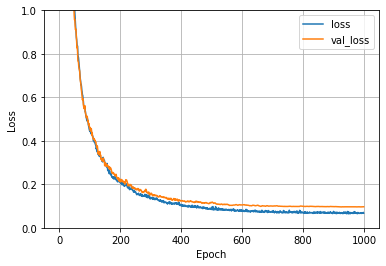

In [79]:
model_full.summary()
plot_loss(H)

R^2 Train: 0.9667425068964097
MAE Train: 0.5780527766576239

R^2 Test: 0.9059054121018928
MAE Test: 0.9200073562524257


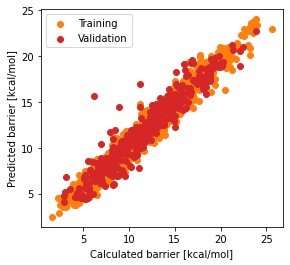

In [54]:
print("R^2 Train: " + str(reg_stats(trainY_scaled, model_full.predict(trainX_cnn), barrierScaler)[0]))
print("MAE Train: " + str(reg_stats(trainY_scaled, model_full.predict(trainX_cnn), barrierScaler)[1]))
print("")
print("R^2 Test: " + str(reg_stats(testY_scaled, model_full.predict(testX_cnn), barrierScaler)[0]))
print("MAE Test: " + str(reg_stats(testY_scaled, model_full.predict(testX_cnn), barrierScaler)[1]))

train_y_pred = barrierScaler.inverse_transform(model_full.predict(trainX_cnn))
train_y_real = barrierScaler.inverse_transform(trainY_scaled)

test_y_pred = barrierScaler.inverse_transform(model_full.predict(testX_cnn))
test_y_real = barrierScaler.inverse_transform(testY_scaled)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(train_y_real, train_y_pred, marker="o", c="C1", label="Training")
ax.scatter(test_y_real, test_y_pred, marker="o", c="C3", label="Validation")
ax.set_aspect('equal')
ax.set_xlabel("Calculated barrier [kcal/mol]")
ax.set_ylabel("Predicted barrier [kcal/mol]")
ax.legend(loc="upper left")

plt.show()

In [49]:
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 100})